### 使用$（r ，\theta ）$的坐标训练神经ODE
question1: 如何固定一个二阶的微分方程网络模型？

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint  # 神经ODE库

#导入数据,数据预处理
df = pd.read_csv('./earth_r_o_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]/(24*60*60*100)                 #以100天为单位，8640000秒
y1 = array[1]/1e11                      #距离为1e11m
y2 = array[2] * 8640000 / 1e11            #速度：100亿米/天
y3 = array[3]                           #弧度无量纲，暂不更改
y4 = array[4]*8640000                     #1rad/100天
y = np.vstack([y1, y2, y3,y4])
print(y.shape)

# 将数据转换为张量格式
coords = torch.tensor(y.T, dtype=torch.float32)
t_tensor = torch.tensor(t,dtype=torch.float32)

print(coords.shape)
print(coords[0])

#定义Stan激活函数
class StanActivation(nn.Module):
    def __init__(self, num_neurons):
        """
        初始化 Stan 激活函数。
        :param num_neurons: 每层的神经元数量，用于定义 beta 参数的大小
        """
        super(StanActivation, self).__init__()
        # 使用 nn.Parameter 初始化 beta，使其参与反向传播
        self.beta = nn.Parameter(torch.ones(num_neurons) * 0.1)  # 使用较小值初始化 beta
    
    def forward(self, x):
        """
        Stan 激活函数的前向计算
        :param x: 输入张量
        :return: 应用 Stan 激活函数后的输出张量
        """
        # 确保 beta 参与计算图
        return (1 + self.beta * x) * torch.tanh(x)


# 2. 定义ODE模型
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4,32 ),
            nn.Tanh(),
            nn.Linear(32, 32)  
        )
        self.fc1 = nn.Linear(32,20)
        self.stan = StanActivation(num_neurons=20)
        self.fc2 = nn.Linear(20,2)

    def forward(self,t, y):
        y2 = self.net(y)
        y2= torch.sin(y2)
        y2 = self.fc1(y2)
        y2 = self.stan(y2)
        y2 = self.fc2(y2)
        return torch.cat([y[1].unsqueeze(0), y2[0].unsqueeze(0), y[3].unsqueeze(0), y2[1].unsqueeze(0)])
    
'''#测试前馈效果，确保满足二阶微分方程关系。
ode_func = ODEFunc()
y0 = coords[0]
print(ode_func.forward(t,y0))'''


#早停用函数
def errors(data):
    mean_value = np.mean(data)
    errors = data - mean_value
    absolute_errors = np.abs(errors)
    mae = np.mean(absolute_errors)
    return mae

#自定义损失函数：
#能量值和角动量
G = 6.67430e-11           # 引力常数, m^3 kg^-1 s^-2
G = G * 8640000**2/1e33   #规整单位
M = 1.989e30              # 太阳质量, kg

def energy(y,G,M):
    r,r_t,theta,theta_t = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
    k = (r_t**2 + (theta_t * r)**2)/2 - G * M /r
    return k 

def angle(y,G,M):
    r,r_t,theta,theta_t = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
    L =  theta_t * r**2
    return L

energy0 = energy(coords,G,M)
angle0 = angle(coords,G,M)

print(energy0,angle0)     #查看效果，还可以

mse_loss_fn = nn.MSELoss()

# 自定义损失函数
class CustomLoss:
    def __init__(self, alpha=0.1, beta=0.1):
        """
        初始化自定义损失函数。
        :param alpha: 平方误差项的系数
        :param beta: 绝对误差项的系数
        """
        self.alpha = alpha
        self.beta = beta

    def __call__(self, y, y_target):
        trajectory_loss = mse_loss_fn(y, y_target)
        energy_loss = torch.mean((energy(y,G,M)-energy0)**2)
        angle_loss = torch.mean((angle(y,G,M)-angle0)**2)
        total_loss = trajectory_loss  + self.alpha * energy_loss + self.beta * angle_loss
        return total_loss


'''# 初始化ODE函数和模型
ode_func = ODEFunc()
optimizer = optim.NAdam(ode_func.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-5)
epochs = 2000'''

# 设置超参数
loss_value = []
mini_delta = 0.005
sum_ = np.array([0,0,0,0,0])

#3. 定义模型训练
def train(model, optimizer, custom_loss, coords, t_tensor, epochs):
    model.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        
        # 神经ODE求解
        pred_y = odeint(model, coords[0], t_tensor)
        
        # 计算损失
        loss = custom_loss(y,pred_y)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        # 打印损失
        if epoch  % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

        #设置早停
        loss_value.append(loss.item())
        if epoch > 5:
            for i in range(5):
                sum_[i] = loss_value[epoch]-loss_value[epoch-i-1]
        err = errors(sum_)/loss.item()

        if loss.item() < 0.001 and err < 0.1 :
            print(f"Epoch {epoch}, Loss: {loss.item()}")
            break

(4, 8760)
torch.Size([8760, 4])
tensor([1.4710, 0.0000, 0.0000, 1.7791])
tensor([-3.3123, -3.3123, -3.3123,  ..., -3.3123, -3.3123, -3.3123]) tensor([3.8497, 3.8497, 3.8497,  ..., 3.8497, 3.8497, 3.8497])


In [ ]:
#设置训练：
model = ODEFunc()
model.load_state_dict(torch.load('ode_orbit_model_weights.pth'))
optimizer = optim.NAdam(model.parameters(), lr=0.005, betas=(0.9, 0.999), weight_decay=1e-5)
epochs = 2000
loss = CustomLoss()

#train(model, optimizer, loss, coords, t_tensor, epochs)


### 将训练结果可视化，检测实际效果，与实际数据对比

In [ ]:
# 4. 可视化结果
model.eval()
with torch.no_grad():
    pred_y = odeint(model, coords[0], t_tensor)
    pred_y = pred_y.numpy()


time = torch.linspace(0,8,800*12)
with torch.no_grad():
    pred_y2 = odeint(model, coords[-1], time)
    pred_y2 = pred_y2.numpy()

pred_y2 = pred_y2.T
rr = pred_y2[0]
oo = pred_y2[2]
x11 = rr * np.cos(oo)
y11 = rr * np.sin(oo)

start = coords[-1].numpy()
print(start)
r_ = start[0]
o_ = start[2]
x_ = r_ * np.cos(o_)
y_ = r_ * np.sin(o_)
print(x_,y_)


# 绘制真实轨迹和预测轨迹
df = pd.read_csv('./earth_r_o_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]/(24*60*60*100)                 #以100天为单位，8640000秒
y1 = array[1]/1e11                      #距离为1e11m
y2 = array[2] * 8640000 / 1e11            #速度：100亿米/天
y3 = array[3]                           #弧度无量纲，暂不更改
y4 = array[4]*8640000                     #rad/100天
y = np.vstack([y1, y2, y3,y4])
print(y.shape)


r1 = y[0]
theta1 = y[2]

# 将极坐标转换为笛卡尔坐标，便于绘图
x1 = r1 * np.cos(theta1)
y1 = r1 * np.sin(theta1)

print(pred_y.shape)
pred_y = pred_y.T
rr = pred_y[0]
oo = pred_y[2]
x = rr * np.cos(oo)
y = rr * np.sin(oo)


plt.figure(figsize=(6, 6))
plt.plot(x1, y1, 'b-', label="True Circle Path")
plt.plot(x, y, 'r--', label="Predicted Path by ODE")
plt.plot(x11,y11 , 'g-', label="Predicted_futher Path by ODE", linewidth = 0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('True Circle and Neural ODE Predicted Path')
plt.gca().set_aspect('equal')
plt.grid()
plt.legend()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'ode_orbit_model_weights.pth')

## 模型调用及效果测试：
SO BAD!出现了对于后续数据不拟合的情况，
### 解决办法1：添加角动量守恒，能量守恒项作为损失函数。将sin层改为cos层，没什么用
使用轨迹残差的损失函数，而使用了能量损失，动量损失表现却更加糟糕
对于使用了能量损失，角动量损失的问题产生更差结果的原因，猜想是数据的近似原因，无法分辨哪个为主要影响

### 解决方法2：首先使用轨迹值训练，导出模型，再使用能量损失来调参，看看效果。
<div style="text-align: center;">
    <img src="output.png" alt="？" width="500"/>
    <p style="text-align: center;">先轨迹值，使用了Stan激活函数，初期收敛确实快！再0.1能量0.1动量的训练，损失:0.023730678483843803</p>
对于这样的情况,使用2000天(5.47年，5圈半)的预测数据，观察到，其没有学习到和时间的强关联性，只有3圈多一点
</div>

### 解决方法3：更换训练数据，换位直角坐标系的微分方程数据

### 解决方法4：使用pinn网络进行学习，在激活函数前层归一化，对于物理约束，提出一下几点方案：
#### 1.不再使用四个变量的mse损失，而重点关注r和$\theta$，即位置的损失，再由能量来约束速度。
<div style="text-align: center;">
    <img src="output5.png" alt="？" width="500"/>
    <p style="text-align: center;">单纯以(r,$\theta$)为坐标损失，不附加能量或角动量损失，效果不太行，损失:0.0191838342</p>
</div>

#### 2.方案1还不行的情况下，直接使用微分方程和能量进行强制约束！即pinn的核心思想。




#### 解决方法4.1：构建只与$r$和$\theta$有关的mse损失函数
<div style="text-align: center;">
    <img src="output6.png" alt="？" width="500"/>
    <p style="text-align: center;">在轨迹上表现要比其他的都好，但是还是不满足时间的关系，</p>
</div>

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint  # 神经ODE库


#导入数据,数据预处理
df = pd.read_csv('./earth_r_o_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]/(24*60*60*100)                 #以100天为单位，8640000秒
y1 = array[1]/1e10                      #距离为1e11m
y2 = array[2] * 8640000 / 1e10           #速度：100亿米/天
y3 = array[3]                           #弧度无量纲，暂不更改
y4 = array[4]*8640000                     #10rad/100天
y = np.vstack([y1, y2, y3,y4])
print(y.shape)

# 将数据转换为张量格式
coords = torch.tensor(y.T, dtype=torch.float32)
t_tensor = torch.tensor(t,dtype=torch.float32)

print(coords.shape)
print(coords[0])

#自定义损失函数：
#能量值和角动量
G = 6.67430e-11           # 引力常数, m^3 kg^-1 s^-2
G = G * 8640000**2/1e30   #规整单位
M = 1.989e30              # 太阳质量, kg

def ro_mse(y,y_target):
    return torch.mean((y[:, 0]-y_target[:,0])**2+(y[:, 2]-y_target[:,2])**2)

def energy(y,G,M):
    r,r_t,theta,theta_t = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
    k = (r_t**2 + (theta_t * r)**2)/2 - G * M /r
    return k 

def angle(y,G,M):
    r,r_t,theta,theta_t = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
    L =  theta_t * r**2
    return L

energy0 = energy(coords,G,M)
angle0 = angle(coords,G,M)

class CustomLoss:
    def __init__(self, alpha=0.1, beta=0.1):
        """
        初始化自定义损失函数。
        :param alpha: 平方误差项的系数
        :param beta: 绝对误差项的系数
        """
        self.alpha = alpha
        self.beta = beta

    def __call__(self, y, y_target):
        trajectory_loss = ro_mse(y, y_target)
        energy_loss = torch.mean((energy(y,G,M)-energy0)**2)
        angle_loss = torch.mean((angle(y,G,M)-angle0)**2)
        if self.alpha != 0 and self.beta != 0:
            return trajectory_loss  + self.alpha * energy_loss + self.beta * angle_loss
        if self.alpha == 0 and self.beta != 0:
            return trajectory_loss  + self.beta * angle_loss
        if self.beta == 0 and self.alpha != 0:
            return trajectory_loss  + self.alpha * energy_loss
        if self.beta == 0 and self.alpha == 0:
            return trajectory_loss

In [ ]:

#定义Stan激活函数
class StanActivation(nn.Module):
    def __init__(self, num_neurons):
        """
        初始化 Stan 激活函数。
        :param num_neurons: 每层的神经元数量，用于定义 beta 参数的大小
        """
        super(StanActivation, self).__init__()
        # 使用 nn.Parameter 初始化 beta，使其参与反向传播
        self.beta = nn.Parameter(torch.ones(num_neurons) * 0.1)  # 使用较小值初始化 beta
    
    def forward(self, x):
        """
        Stan 激活函数的前向计算
        :param x: 输入张量
        :return: 应用 Stan 激活函数后的输出张量
        """
        # 确保 beta 参与计算图
        return (1 + self.beta * x) * torch.tanh(x)


# 2. 定义ODE模型
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4,32 ),
            nn.Tanh(),
            nn.Linear(32, 32)  
        )
        self.fc1 = nn.Linear(32,20)
        self.stan = StanActivation(num_neurons=20)
        self.fc2 = nn.Linear(20,2)

    def forward(self,t, y):
        y2 = self.net(y)
        y2= torch.sin(y2)
        y2 = self.fc1(y2)
        y2 = self.stan(y2)
        y2 = self.fc2(y2)
        return torch.cat([y[1].unsqueeze(0), y2[0].unsqueeze(0), y[3].unsqueeze(0), y2[1].unsqueeze(0)])
    
'''#测试前馈效果，确保满足二阶微分方程关系。
ode_func = ODEFunc()
y0 = coords[0]
print(ode_func.forward(t,y0))'''


#早停用函数
def errors(data):
    mean_value = np.mean(data)
    errors = data - mean_value
    absolute_errors = np.abs(errors)
    mae = np.mean(absolute_errors)
    return mae

#超参数设置
loss_value = []
mini_delta = 0.005
sum_ = np.array([0,0,0,0,0])

#3. 定义模型训练
def train(model, optimizer, custom_loss, coords, t_tensor, epochs):
    model.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        
        # 神经ODE求解
        pred_y = odeint(model, coords[0], t_tensor)
        
        # 计算损失
        loss = custom_loss(pred_y,coords)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        # 打印损失
        if epoch  % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

        #设置早停
        loss_value.append(loss.item())
        if epoch > 5:
            for i in range(5):
                sum_[i] = loss_value[epoch]-loss_value[epoch-i-1]
        err = errors(sum_)/loss.item()

        if loss.item() < 0.001 and err < 0.1 :
            print(f"Epoch {epoch}, Loss: {loss.item()}")
            break

In [ ]:
#设置训练：
model = ODEFunc()
optimizer = optim.NAdam(model.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=1e-3)
epochs = 2000
loss = CustomLoss(0.01,0.01)

train(model, optimizer, loss, coords, t_tensor, epochs)

In [ ]:
model.eval()
time = torch.linspace(0,20,2000*12)
with torch.no_grad():
    pred_y = odeint(model, coords[0], time)
    pred_y = pred_y.numpy()
    pred_y2 = odeint(model, coords[-1], time)
    pred_y2 = pred_y2.numpy()


pred_y2 = pred_y2.T
rr = pred_y2[0]
oo = pred_y2[2]
x11 = rr * np.cos(oo)
y11 = rr * np.sin(oo)


r1 = coords[:,0]
theta1 = coords[:,2]

# 将极坐标转换为笛卡尔坐标，便于绘图
x1 = r1 * np.cos(theta1)
y1 = r1 * np.sin(theta1)

print(pred_y.shape)
pred_y = pred_y.T
rr = pred_y[0]
oo = pred_y[2]
x = rr * np.cos(oo)
y = rr * np.sin(oo)


plt.figure(figsize=(6, 6))
plt.plot(x1, y1, 'b-', label="True Circle Path")
plt.plot(x, y, 'r--', label="Predicted Path by ODE")
plt.plot(x11,y11 , 'g-', label="Predicted_futher Path by ODE", linewidth = 0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('True Circle and Neural ODE Predicted Path')
plt.gca().set_aspect('equal')
plt.grid()
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'ode_orbit_model_weights.pth')

### 解决方法4.2：直接使用微分方程约束
1. 径向运动方程：

$$
\ddot{r} = r \dot{\theta}^2 - \frac{G M}{r^2}
$$

2. 角度运动方程：

$$
\ddot{\theta} + \frac{2 \dot{r}}{r} \dot{\theta} = 0
$$

1. 难点在于，并没有加速度数据，如果使用数值差分表示$\ddot{\theta}(t) = \frac{\dot{\theta}(t+\Delta) -\dot{\theta}(t-\Delta)}{2\Delta}$,自然的产生数值误差，或许仍然不能够学习到,还有关键的一点在于，$\dot{\theta}$ or $\dot{r}$ 无显式表达，在求解上也是只能用已有数据估算，这样看来似乎无法去解这个问题。
不对，神经网络本就学的是一个加速度表达式，即二阶的微分。
<div style="text-align: center;">
    <img src="output7.png" alt="？" width="500"/>
    <p style="text-align: center;">使用微分方程直接约束，并再激活函数前层归一化，使用单独的（r,theta)均方误差，loss3.972147169406526e-05</p>
</div>
效果依旧不好，猜r总是发散，不形成一个稳定的周期函数。测是由于无法学习到r的周期性变化，大致可以看出theta的学习效果要比R好多了。
在之前的训练中，数据范围内确实可以学习到一个椭圆，但是已超过数据范围就逐渐发散，很像多项式拟合SIN函数的情况。




In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint  # 神经ODE库


#导入数据,数据预处理
df = pd.read_csv('./earth_r_o_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]/(24*60*60*100)                 #以100天为单位，8640000秒
y1 = array[1]/1e10                      #距离为1e11m
y2 = array[2] * 8640000 / 1e10           #速度：100亿米/天
y3 = array[3]                           #弧度无量纲，暂不更改
y4 = array[4]*8640000                     #10rad/100天
y = np.vstack([y1, y2, y3,y4])
print(y.shape)

# 将数据转换为张量格式
coords = torch.tensor(y.T, dtype=torch.float32)
t_tensor = torch.tensor(t,dtype=torch.float32)

print(coords.shape)
print(coords[0])

In [ ]:
class StanActivation(nn.Module):
    def __init__(self, num_neurons):
        """
        初始化 Stan 激活函数。
        :param num_neurons: 每层的神经元数量，用于定义 beta 参数的大小
        """
        super(StanActivation, self).__init__()
        # 使用 nn.Parameter 初始化 beta，使其参与反向传播
        self.beta = nn.Parameter(torch.ones(num_neurons) * 0.1)  # 使用较小值初始化 beta
    
    def forward(self, x):
        """
        Stan 激活函数的前向计算
        :param x: 输入张量
        :return: 应用 Stan 激活函数后的输出张量
        """
        # 确保 beta 参与计算图
        return (1 + self.beta * x) * torch.tanh(x)

# 自定义ODE模型
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 32),
            nn.Tanh(),
            nn.Linear(32, 32)
        ) 
        self.fc1_norm = nn.LayerNorm(32) 
        self.fc1 = nn.Linear(32, 20)
        self.fc2_norm = nn.LayerNorm(20)
        self.stan = StanActivation(num_neurons=20)
        self.fc2 = nn.Linear(20, 2)  # 假定为二阶导数的输出

    def forward(self, t, y):
        # 网络计算二阶导数值
        y2 = self.net(y)
        y2 = self.fc1_norm(y2)
        y2 = torch.sin(y2)
        y2 = self.fc1(y2)
        y2= self.fc2_norm(y2)
        y2 = self.stan(y2)
        y2 = self.fc2(y2)  # y2 的形状为 (batch_size, 2)
        
        # 拼接成 4 维的输出，其中 y2 的两项为二阶导数假定值
        return torch.cat([y[:, 1:2], y2[:, :1], y[:, 3:4], y2[:, 1:2]], dim=1)

# 计算真实二阶导数
def compute_actual_second_order(coords, G, M):
    r, r_t, theta, theta_t = coords[:, 0], coords[:, 1], coords[:, 2], coords[:, 3]
    r_tt_actual = (-G * M / r**2 + r * theta_t**2).unsqueeze(1)
    theta_tt_actual = (-2 * r_t * theta_t / r).unsqueeze(1)
    return torch.cat([r_tt_actual, theta_tt_actual], dim=1)

# 自定义损失函数
class CombinedLoss(nn.Module):
    def __init__(self, G, M, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.G = G
        self.M = M
        self.alpha = alpha  # 权重系数，用于平衡两个损失

    def forward(self, pred_y2, coords, pred_trajectory):
        # 计算真实的二阶导数
        actual_second_order = compute_actual_second_order(coords, self.G, self.M)
        
        # 提取预测的二阶导数部分 (第2和第4项)
        pred_second_order = pred_y2[:, [1, 3]]
        
        # 二阶导数损失
        second_order_loss = torch.mean((pred_second_order - actual_second_order) ** 2)
        
        # 积分轨迹损失
        trajectory_loss = torch.mean((pred_trajectory - coords) ** 2)
        
        # 组合损失
        return self.alpha * second_order_loss + (1 - self.alpha) * trajectory_loss

# 初始化参数
G = 6.67430e-11 * (8640000**2) / 1e30
M = 1.989e30
loss_fn = CombinedLoss(G, M, alpha=0.5)  # 设置alpha平衡系数
ode_func = ODEFunc()
optimizer = torch.optim.Adam(ode_func.parameters(), lr=0.01)

# 训练过程
def train(model, optimizer, loss_fn, coords, t_tensor, epochs):
    model.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        
        # 1. 使用 model.forward 直接计算二阶导数的预测值
        pred_y2 = model.forward(None, coords)
        
        # 2. 使用 odeint 进行积分，获得预测的轨迹
        initial_state = coords[0].unsqueeze(0)  # 初始状态
        pred_trajectory = odeint(model, initial_state, t_tensor).squeeze(1)  # 去掉 batch 维度
        
        # 计算组合损失
        loss = loss_fn(pred_y2, coords, pred_trajectory)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印损失
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# 运行训练
train(ode_func, optimizer, loss_fn, coords, t_tensor, epochs=3000)


In [ ]:


# 假设 `ode_func` 和 `coords`, `time` 已经定义，下面是无梯度预测和绘图部分
model.eval()
time = torch.linspace(0,7,700*12)
with torch.no_grad():
    # 使用 coords[0].unsqueeze(0) 来确保维度匹配
    initial_state = coords[0].unsqueeze(0)  # 初始状态维度为 (1, 4)
    
    # 使用 odeint 计算预测轨迹
    pred_y = odeint(ode_func, initial_state, time)  # 形状为 (time_steps, 1, 4)
    pred_y = pred_y.squeeze(1).numpy()  # 去除批次维度，得到 (time_steps, 4)
    
    # 使用 coords[-1] 作为初始状态进行另一次预测
    initial_state_last = coords[-1].unsqueeze(0)  # 维度为 (1, 4)
    pred_y2 = odeint(ode_func, initial_state_last, time)  # 形状为 (time_steps, 1, 4)
    pred_y2 = pred_y2.squeeze(1).numpy()  # 去除批次维度

# 转置 pred_y2 以便提取所需的值
pred_y2 = pred_y2.T
rr = pred_y2[0]  # 距离
oo = pred_y2[2]  # 角度

# 计算 x11 和 y11 的坐标
x11 = rr * np.cos(oo)
y11 = rr * np.sin(oo)


pred_y = pred_y.T
r = pred_y[0]
o = pred_y[2]
x = rr * np.cos(o)
y = rr * np.sin(o)


# 绘制结果
plt.figure(figsize=(8, 8))
plt.plot(x, y, 'r--', label="Predicted Path by ODE")
plt.plot(x11, y11, label="Predicted Trajectory", color="blue")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Trajectory in Polar Coordinates")
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'ode2_orbit_model_weights.pth')

## 1.附录：在研究网络结构的过程中，发现对于线性组合的模式，并不能通过简单的加深网络深度来构成，或许可以尝试构造多头网络来拟合，下面进行尝试
使用两个三层线性层的网络，激活函数使用sin和Stan

<div style="text-align: center;">
    <img src="output8.png" alt="？" width="500"/>
    <p style="text-align: center;">使用微分方程直接约束，使用单独的（r,theta)均方误差,beta = 0.2，loss:0.0003374747757334262</p>
</div>

### 1.1数据导入

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint  # 神经ODE库


#导入数据,数据预处理
df = pd.read_csv('./earth_r_o_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]/(24*60*60*100)                 #以100天为单位，8640000秒
y1 = array[1]/1e10                      #距离为1e11m
y2 = array[2] * 8640000 / 1e10           #速度：100亿米/天
y3 = array[3]                           #弧度无量纲，暂不更改
y4 = array[4]*8640000                     #10rad/100天
y = np.vstack([y1, y2, y3,y4])
print(y.shape)

# 将数据转换为张量格式
coords = torch.tensor(y.T, dtype=torch.float32)
t_tensor = torch.tensor(t,dtype=torch.float32)

print(coords.shape)
print(coords[0])

(4, 8760)
torch.Size([8760, 4])
tensor([14.7100,  0.0000,  0.0000,  1.7791])


### 1.2.模型构建

In [8]:
class StanActivation(nn.Module):
    def __init__(self, num_neurons):
        """
        初始化 Stan 激活函数。
        :param num_neurons: 每层的神经元数量，用于定义 beta 参数的大小
        """
        super(StanActivation, self).__init__()
        # 使用 nn.Parameter 初始化 beta，使其参与反向传播
        self.beta = nn.Parameter(torch.ones(num_neurons) * 0.1)  # 使用较小值初始化 beta
    
    def forward(self, x):
        """
        Stan 激活函数的前向计算
        :param x: 输入张量
        :return: 应用 Stan 激活函数后的输出张量
        """
        # 确保 beta 参与计算图
        return (1 + self.beta * x) * torch.tanh(x)

# 自定义ODE模型
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.fc1 = nn.Linear(4, 20)
        self.stan = StanActivation(num_neurons=20)
        self.fc2 = nn.Linear(20, 20)  # 假定为二阶导数的输出
        self.fc3 = nn.Linear(20, 2)

        self.fc11 = nn.Linear(4, 20)
        self.fc22 = nn.Linear(20, 20)  
        self.fc33 = nn.Linear(20, 2)

    def forward(self, t, y):
        # 网络计算二阶导数值
        y1 = self.fc1(y)
        y1 = self.stan(y1)
        y1 = self.fc2(y1)
        y1 = torch.sin(y1)
        y1 = self.fc3(y1)  # y2 的形状为 (batch_size, 2)

        y3 = self.fc11(y)
        y3 = self.stan(y3)
        y3 = self.fc22(y3)
        y3 = torch.sin(y3)
        y3 = self.fc33(y3)  # y2 的形状为 (batch_size, 2)

        y2 = y1 + y3
       
        # 拼接成 4 维的输出，其中 y2 的两项为二阶导数假定值
        return torch.cat([y[:, 1:2], y2[:, :1], y[:, 3:4], y2[:, 1:2]], dim=1)

# 计算真实二阶导数
def compute_actual_second_order(coords, G, M):
    r, r_t, theta, theta_t = coords[:, 0], coords[:, 1], coords[:, 2], coords[:, 3]
    r_tt_actual = (-G * M / r**2 + r * theta_t**2).unsqueeze(1)
    theta_tt_actual = (-2 * r_t * theta_t / r).unsqueeze(1)
    return torch.cat([r_tt_actual, theta_tt_actual], dim=1)

# 自定义损失函数
class CombinedLoss(nn.Module):
    def __init__(self, G, M, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.G = G
        self.M = M
        self.alpha = alpha  # 权重系数，用于平衡两个损失

    def forward(self, pred_y2, coords, pred_trajectory):
        # 计算真实的二阶导数
        actual_second_order = compute_actual_second_order(coords, self.G, self.M)
        
        # 提取预测的二阶导数部分 (第2和第4项)
        pred_second_order = pred_y2[:, [1, 3]]
        
        # 二阶导数损失
        second_order_loss = torch.mean((pred_second_order - actual_second_order) ** 2)
        
        # 积分轨迹损失
        trajectory_loss = torch.mean((pred_trajectory - coords) ** 2)
        
        # 组合损失
        return self.alpha * second_order_loss + (1 - self.alpha) * trajectory_loss



# 训练过程
def train(model, optimizer, loss_fn, coords, t_tensor, epochs):
    model.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        
        # 1. 使用 model.forward 直接计算二阶导数的预测值
        pred_y2 = model.forward(None, coords)
        
        # 2. 使用 odeint 进行积分，获得预测的轨迹
        initial_state = coords[0].unsqueeze(0)  # 初始状态
        pred_trajectory = odeint(model, initial_state, t_tensor).squeeze(1)  # 去掉 batch 维度
        
        # 计算组合损失
        loss = loss_fn(pred_y2, coords, pred_trajectory)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印损失
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

In [13]:
# 初始化参数
G = 6.67430e-11 * (8640000**2) / 1e30
M = 1.989e30
loss_fn = CombinedLoss(G, M, alpha=0.2)  # 设置alpha平衡系数
ode_func = ODEFunc()
optimizer = torch.optim.Adam(ode_func.parameters(), lr=0.005)
# 运行训练
train(ode_func, optimizer, loss_fn, coords, t_tensor, epochs=2000)

Epoch 0, Loss: 14.255252838134766
Epoch 200, Loss: 0.05174711346626282
Epoch 400, Loss: 0.04670723155140877
Epoch 600, Loss: 0.03890018165111542
Epoch 800, Loss: 0.0275740884244442
Epoch 1000, Loss: 0.017483826726675034
Epoch 1200, Loss: 0.00780593603849411
Epoch 1400, Loss: 0.0040032994002103806
Epoch 1600, Loss: 0.001180747407488525
Epoch 1800, Loss: 0.00102993322070688
Epoch 2000, Loss: 0.0003374747757334262


In [ ]:
torch.save(model.state_dict(), 'ode3_orbit_model_weights.pth')

### 1.3.效果观察

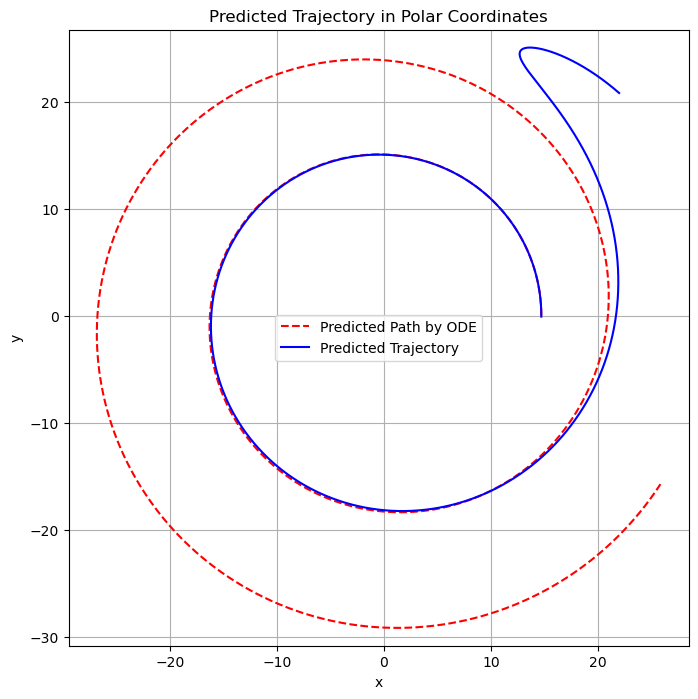

In [14]:
ode_func.eval()
time = torch.linspace(0,7,700*12)
with torch.no_grad():
    # 使用 coords[0].unsqueeze(0) 来确保维度匹配
    initial_state = coords[0].unsqueeze(0)  # 初始状态维度为 (1, 4)
    
    # 使用 odeint 计算预测轨迹
    pred_y = odeint(ode_func, initial_state, time)  # 形状为 (time_steps, 1, 4)
    pred_y = pred_y.squeeze(1).numpy()  # 去除批次维度，得到 (time_steps, 4)
    
    # 使用 coords[-1] 作为初始状态进行另一次预测
    initial_state_last = coords[-1].unsqueeze(0)  # 维度为 (1, 4)
    pred_y2 = odeint(ode_func, initial_state_last, time)  # 形状为 (time_steps, 1, 4)
    pred_y2 = pred_y2.squeeze(1).numpy()  # 去除批次维度

# 转置 pred_y2 以便提取所需的值
pred_y2 = pred_y2.T
rr = pred_y2[0]  # 距离
oo = pred_y2[2]  # 角度

# 计算 x11 和 y11 的坐标
x11 = rr * np.cos(oo)
y11 = rr * np.sin(oo)


pred_y = pred_y.T
r = pred_y[0]
o = pred_y[2]
x = rr * np.cos(o)
y = rr * np.sin(o)


# 绘制结果
plt.figure(figsize=(8, 8))
plt.plot(x, y, 'r--', label="Predicted Path by ODE")
plt.plot(x11, y11, label="Predicted Trajectory", color="blue")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Trajectory in Polar Coordinates")
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()